# Continuous Attractor Neural Network
## The dynamics of the model
### Synaptic current dynamics (exponential conductance model): 
$$ 
\tau\frac{dU(x,t)}{dt} = -U(x,t)+I^{rec} (x,t)+ I^{ext}(x,t)
$$
where the recurrent input $I_{rec}(x,t) = \int_{x'}J(x,x')r(x',t)dx'$, which represents a weighted sum of all recurrently connected neurons' firing rate,
### Activation function (which transfer the synaptic current to firing rates):
$$
r(x,t) = \frac{U(x,t)^2}{1+k\int_x' U(x',t)^2dx'}
$$
### Synaptic connection strength matrix
$$
J(x,t) = J_0 exp [-\frac{dist(x，x')^2}{2a^2}]
$$
where $dist(x, x')$ represents the distance of two features, e.g., in Euler space the $dist(x,x') = |x-x'|$.
## Customize a ring CANN in brainpy
In simulations, we can not simulate a CANN encoding features ranging $(-\inf, \inf)$. Instead, we simulate a ring attractor network which encodes features ranging $(-\pi, \pi)$. Note that the distance on a ring should be:
$$
dist_{ring}(x,x') = min(|x-x'|,2\pi-|x-x'|)
$$


![dasda](figs/s01apgi89t.png)

In [66]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 15})
plt.rcParams['font.sans-serif'] = ['Times New Roman']


class CANN1D(bp.NeuGroupNS):
  def __init__(self, num, tau=1., k=8.1, a=0.5, A=10., J0=4.,
               z_min=-bm.pi, z_max=bm.pi, **kwargs):
    super(CANN1D, self).__init__(size=num, **kwargs)

    # 初始化参数
    self.tau = tau
    self.k = k
    self.a = a
    self.A = A
    self.J0 = J0

    # 初始化特征空间相关参数
    self.z_min = z_min
    self.z_max = z_max
    self.z_range = z_max - z_min
    self.x = bm.linspace(z_min, z_max, num)
    self.rho = num / self.z_range
    self.dx = self.z_range / num

    # 初始化变量
    self.u = bm.Variable(bm.zeros(num))
    self.input = bm.Variable(bm.zeros(num))
    self.conn_mat = self.make_conn(self.x)  # 连接矩阵

    # 定义积分函数
    self.integral = bp.odeint(self.derivative)

  # 微分方程
  @property
  def derivative(self):
    du = lambda u, t, Irec, Iext: (-u + Irec + Iext) / self.tau
    return du

  # 将距离转换到[-z_range/2, z_range/2)之间
  def dist(self, d):
    d = bm.remainder(d, self.z_range)
    d = bm.where(d > 0.5 * self.z_range, d - self.z_range, d)
    return d

  # 计算连接矩阵
  def make_conn(self, x):
    assert bm.ndim(x) == 1
    d = self.dist(x - x[:, None])  # 距离矩阵
    Jxx = self.J0 * bm.exp(
      -0.5 * bm.square(d / self.a)) / (bm.sqrt(2 * bm.pi) * self.a) 
    return Jxx

  # 获取各个神经元到pos处神经元的输入
  def get_stimulus_by_pos(self, pos):
    return self.A * bm.exp(-0.25 * bm.square(self.dist(self.x - pos) / self.a))

  def update(self, x=None):
    _t = bp.share['t']
    u2 = bm.square(self.u)
    r = u2 / (1.0 + self.k * bm.sum(u2))
    Irec = bm.dot(self.conn_mat, r)
    self.u[:] = self.integral(self.u, _t,Irec, self.input)
    self.input[:] = 0.  # 重置外部电流

## Simulate the persistent activity of CANN after the removal of external input
We first project a gaussian-bump external input to activate CANN, then remove it and check the population response of CANN.

  0%|          | 0/220 [00:00<?, ?it/s]

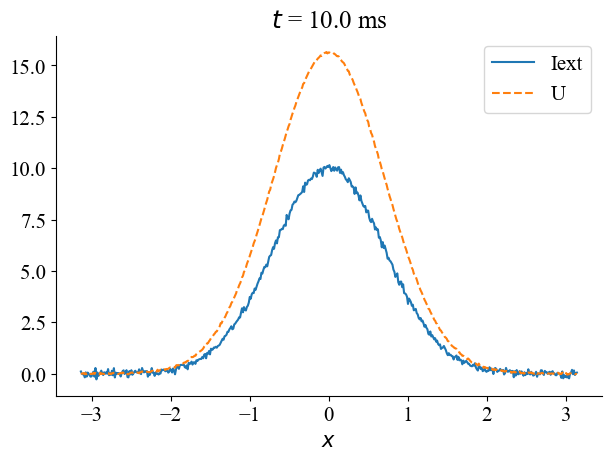

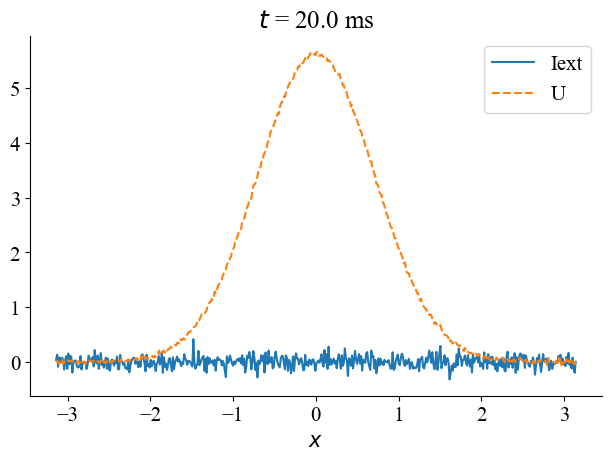

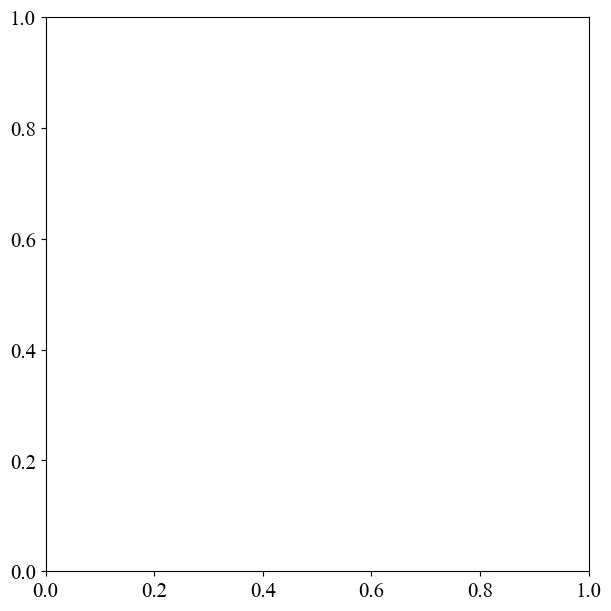

In [67]:
def Persistent_Activity(k=0.1,J0=1.):
    # 生成CANN
    cann = CANN1D(num=512, k=k,J0=J0)

    # 生成外部刺激，从第2到12ms，持续10ms
    dur1, dur2, dur3 = 2., 10., 10.
    I1 = cann.get_stimulus_by_pos(0.)
    Iext, duration = bp.inputs.section_input(values=[0., I1, 0.],
                                             durations=[dur1, dur2, dur3],
                                             return_length=True)
    noise_level = 0.1
    noise = bm.random.normal(0., noise_level, (int(duration / bm.get_dt()), len(I1)))
    Iext += noise
    # 运行数值模拟
    runner = bp.DSRunner(cann, inputs=['input', Iext, 'iter'], monitors=['u'])
    runner.run(duration)

    # 可视化
    def plot_response(t):
        fig, gs = bp.visualize.get_figure(1, 1, 4.5, 6)
        ax = fig.add_subplot(gs[0, 0])
        ts = int(t / bm.get_dt())
        I, u = Iext[ts], runner.mon.u[ts]
        ax.plot(cann.x, I, label='Iext')
        ax.plot(cann.x, u, linestyle='dashed', label='U')
        ax.set_title(r'$t$' + ' = {} ms'.format(t))
        ax.set_xlabel(r'$x$')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend()
        # plt.savefig(f'CANN_t={t}.pdf', transparent=True, dpi=500)

    plot_response(t=10.)
    plot_response(t=20.)

    bp.visualize.animate_1D(
        dynamical_vars=[{'ys': runner.mon.u, 'xs': cann.x, 'legend': 'u'},
                        {'ys': Iext, 'xs': cann.x, 'legend': 'Iext'}],
        frame_step=1,
        frame_delay=40,
        show=True,
    )
    plt.show()
Persistent_Activity(k=0.1)

## Simulate the tracking behavior of CANN
We first project a moving gaussian-bump input to CANN and check the population response of CANN.

  0%|          | 0/400 [00:00<?, ?it/s]

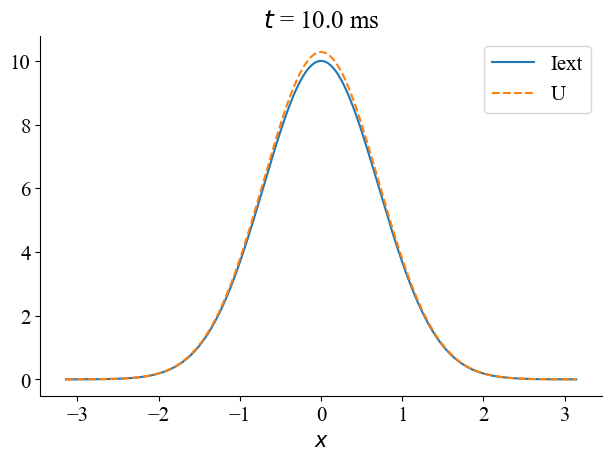

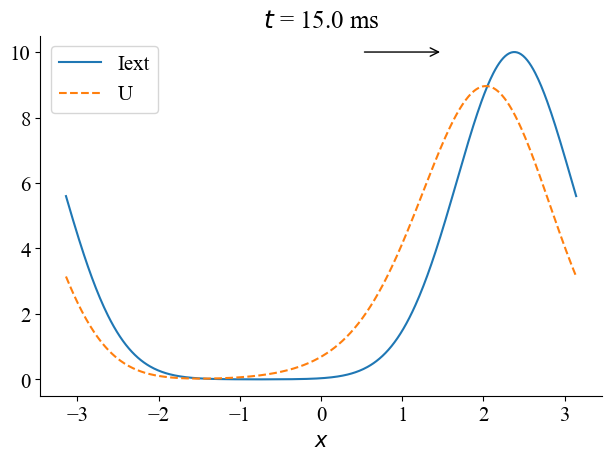

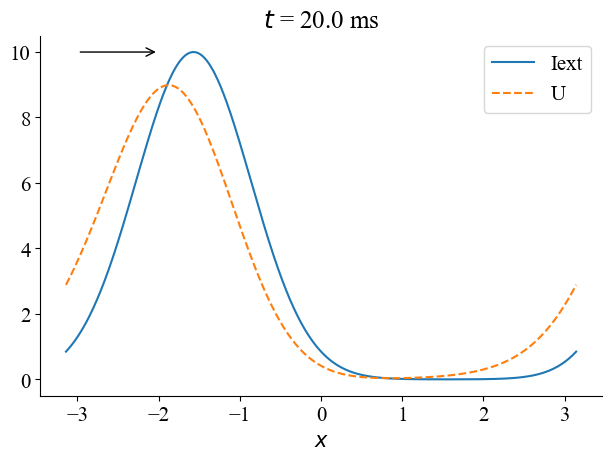

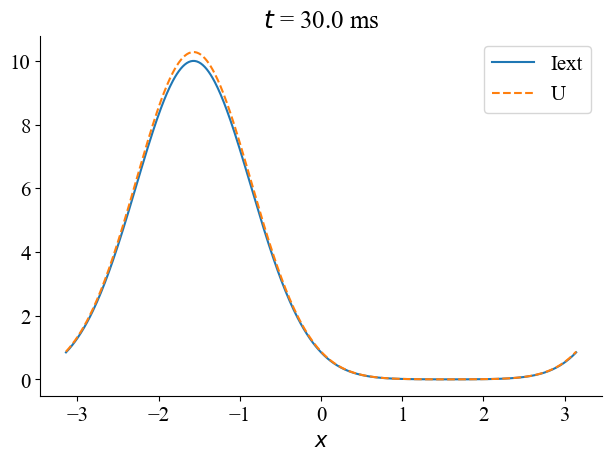

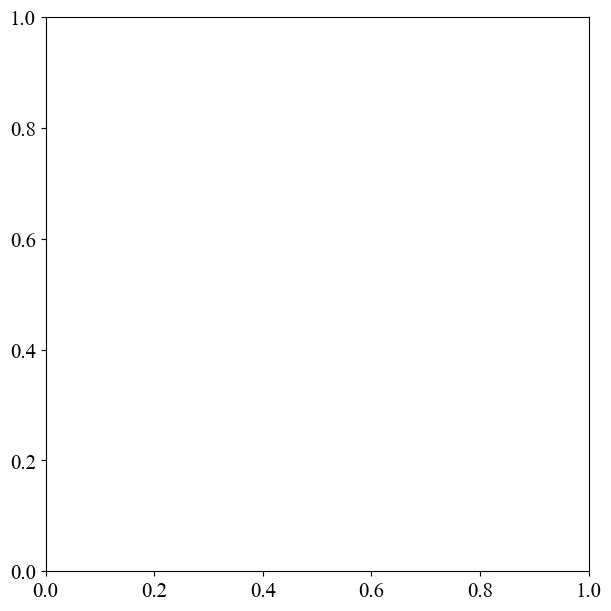

In [70]:

def smooth_tracking():
    cann = CANN1D(num=512, k=8.1)

    # 定义随时间变化的外部刺激
    v_ext = 1e-3
    dur1, dur2, dur3 = 10., 10., 20
    num1 = int(dur1 / bm.get_dt())
    num2 = int(dur2 / bm.get_dt())
    num3 = int(dur3 / bm.get_dt())
    position = bm.zeros(num1 + num2 + num3)
    position[num1: num1 + num2] = bm.linspace(0., 1.5 * bm.pi, num2)
    position[num1 + num2: ] = 1.5 * bm.pi
    position = position.reshape((-1, 1))
    Iext = cann.get_stimulus_by_pos(position)

    # 运行模拟
    runner = bp.DSRunner(cann,
                         inputs=['input', Iext, 'iter'],
                         monitors=['u'])
    runner.run(dur1 + dur2 + dur3)

    # 可视化
    def plot_response(t, extra_fun=None):
        fig, gs = bp.visualize.get_figure(1, 1, 4.5, 6)
        ax = fig.add_subplot(gs[0, 0])
        ts = int(t / bm.get_dt())
        I, u = Iext[ts], runner.mon.u[ts]
        ax.plot(cann.x, I, label='Iext')
        ax.plot(cann.x, u, linestyle='dashed', label='U')
        ax.set_title(r'$t$' + ' = {} ms'.format(t))
        ax.set_xlabel(r'$x$')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend()
        if extra_fun: extra_fun()
        # plt.savefig(f'CANN_tracking_t={t}.pdf', transparent=True, dpi=500)

    plot_response(t=10.)

    def f():
        plt.annotate('', xy=(1.5, 10), xytext=(0.5, 10), arrowprops=dict(arrowstyle="->"))

    plot_response(t=15., extra_fun=f)

    def f():
        plt.annotate('', xy=(-2, 10), xytext=(-3, 10), arrowprops=dict(arrowstyle="->"))

    plot_response(t=20., extra_fun=f)
    plot_response(t=30.)

    bp.visualize.animate_1D(
        dynamical_vars=[{'ys': runner.mon.u, 'xs': cann.x, 'legend': 'u'},
                        {'ys': Iext, 'xs': cann.x, 'legend': 'Iext'}],
        frame_step=5,
        frame_delay=50,
        show=True,
    )
    plt.show()
smooth_tracking()

# Adaptive Continuous Attractor Neural Network
## The dynamics of CANN with SFA
### Synaptic current dynamics (a negative feedback current $V$ is added to the model): 
$$ 
\tau \frac{dU(x,t)}{dt} = -U(x,t)+\int_x' J(x,x')r(x',t)dx' + I^{ext} - V(x,t)
$$
### Spike frequency adaptation (dynamics of V): 
$$ 
\tau_v \frac{dV(x,t)}{dt} = -V(x,t)+ mU(x,t)
$$
## Customize a CANN with SFA

In [71]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 15})
plt.rcParams['font.sans-serif'] = ['Times New Roman']


class CANN1D_SFA(bp.NeuGroupNS):
  def __init__(self, num, m = 0.1, tau=1., tau_v=10., k=8.1, a=0.5, A=10., J0=4.,
               z_min=-bm.pi, z_max=bm.pi, **kwargs):
    super(CANN1D_SFA, self).__init__(size=num, **kwargs)

    # 初始化参数
    self.tau = tau
    self.tau_v = tau_v #time constant of SFA
    self.k = k
    self.a = a
    self.A = A
    self.J0 = J0
    self.m = m #SFA strength
      
    # 初始化特征空间相关参数
    self.z_min = z_min
    self.z_max = z_max
    self.z_range = z_max - z_min
    self.x = bm.linspace(z_min, z_max, num)
    self.rho = num / self.z_range
    self.dx = self.z_range / num

    # 初始化变量
    self.u = bm.Variable(bm.zeros(num))
    self.v = bm.Variable(bm.zeros(num)) #SFA current
    self.input = bm.Variable(bm.zeros(num))
    self.conn_mat = self.make_conn(self.x)  # 连接矩阵

    # 定义积分函数
    self.integral = bp.odeint(self.derivative)

  # 微分方程
  @property
  def derivative(self):
    du = lambda u, t, v, Irec, Iext: (-u + Irec + Iext-v) / self.tau
    dv = lambda v, t, u: (-v + self.m*u) / self.tau_v
    return bp.JointEq([du, dv])

  # 将距离转换到[-z_range/2, z_range/2)之间
  def dist(self, d):
    d = bm.remainder(d, self.z_range)
    d = bm.where(d > 0.5 * self.z_range, d - self.z_range, d)
    return d

  # 计算连接矩阵
  def make_conn(self, x):
    assert bm.ndim(x) == 1
    d = self.dist(x - x[:, None])  # 距离矩阵
    Jxx = self.J0 * bm.exp(
      -0.5 * bm.square(d / self.a)) / (bm.sqrt(2 * bm.pi) * self.a) 
    return Jxx

  # 获取各个神经元到pos处神经元的输入
  def get_stimulus_by_pos(self, pos):
    return self.A * bm.exp(-0.25 * bm.square(self.dist(self.x - pos) / self.a))

  def update(self, x=None):
    u2 = bm.square(self.u)
    r = u2 / (1.0 + self.k * bm.sum(u2))
    Irec = bm.dot(self.conn_mat, r)
    u, v = self.integral(self.u, self.v, bp.share['t'],Irec, self.input)
    self.u[:] = bm.where(u>0,u,0)
    self.v[:] = v
    self.input[:] = 0.  # 重置外部电流

## Simulate the spontaneous traveling wave
We project a random noise into CANN, the network can spontaneously generate a bump traveling through the space.

  0%|          | 0/10000 [00:00<?, ?it/s]

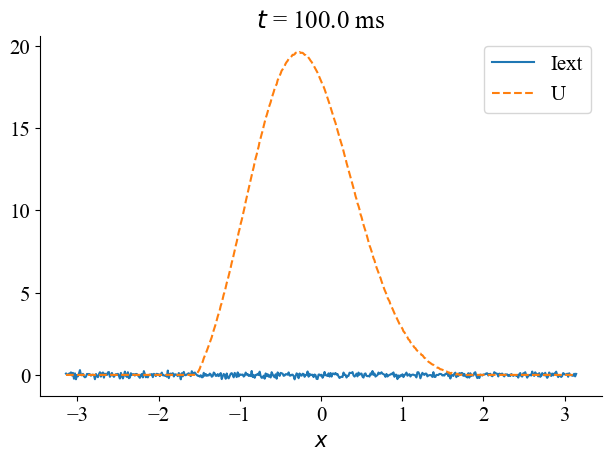

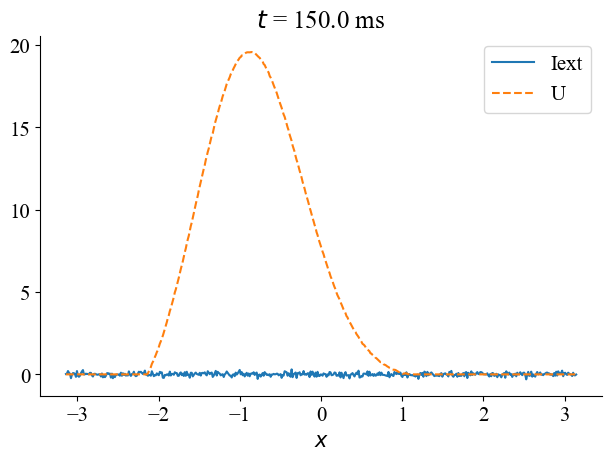

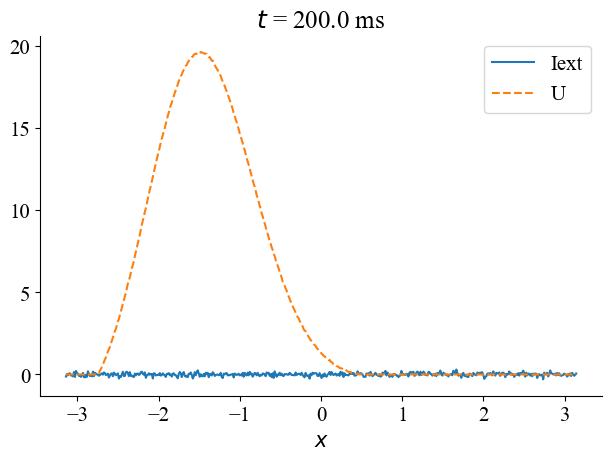

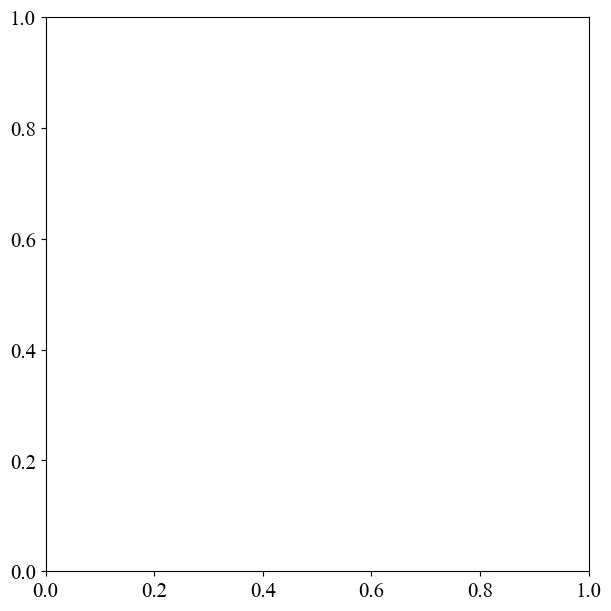

In [74]:
def traveling_wave(num=512,m=0.1,k=0.1):
    # 生成CANN
    cann_sfa = CANN1D_SFA(num=num, m=m,k=k)

    # 生成外部刺激
    dur = 1000.
    noise_level = 0.1
    Iext = bm.random.normal(0., noise_level, (int(dur / bm.get_dt()), num))
    duration = dur
    # 运行数值模拟
    runner = bp.DSRunner(cann_sfa, inputs=['input', Iext, 'iter'], monitors=['u'])
    runner.run(duration)

    # 可视化
    def plot_response(t):
        fig, gs = bp.visualize.get_figure(1, 1, 4.5, 6)
        ax = fig.add_subplot(gs[0, 0])
        ts = int(t / bm.get_dt())
        I, u = Iext[ts], runner.mon.u[ts]
        ax.plot(cann_sfa.x, I, label='Iext')
        ax.plot(cann_sfa.x, u, linestyle='dashed', label='U')
        ax.set_title(r'$t$' + ' = {} ms'.format(t))
        ax.set_xlabel(r'$x$')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend()
        # plt.savefig(f'CANN_t={t}.pdf', transparent=True, dpi=500)

    plot_response(t=100.)
    plot_response(t=150.)
    plot_response(t=200.)

    bp.visualize.animate_1D(
        dynamical_vars=[{'ys': runner.mon.u, 'xs': cann_sfa.x, 'legend': 'u'},
                        {'ys': Iext, 'xs': cann_sfa.x, 'legend': 'Iext'}],
        frame_step=1,
        frame_delay=40,
        show=True,
    )
    plt.show()
    
traveling_wave(num=512,m=0.5,k=0.1)

## Simulate the anticipative tracking
We project a moving inputinto A-CANN, the network generate a bump anticipatively tracking the stimulus.

  0%|          | 0/10100 [00:00<?, ?it/s]

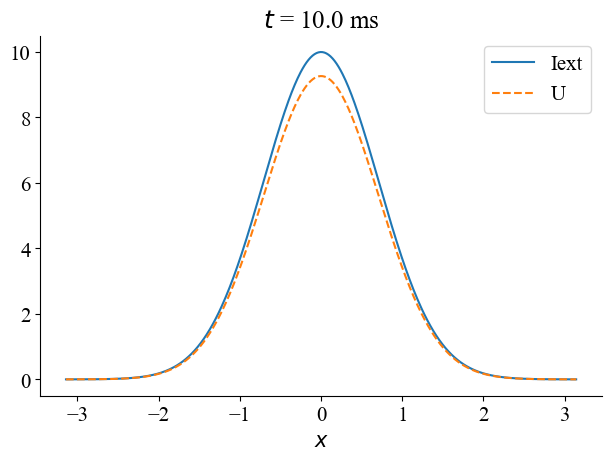

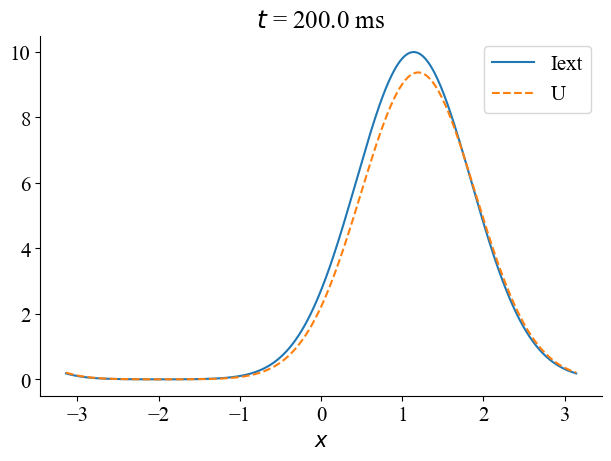

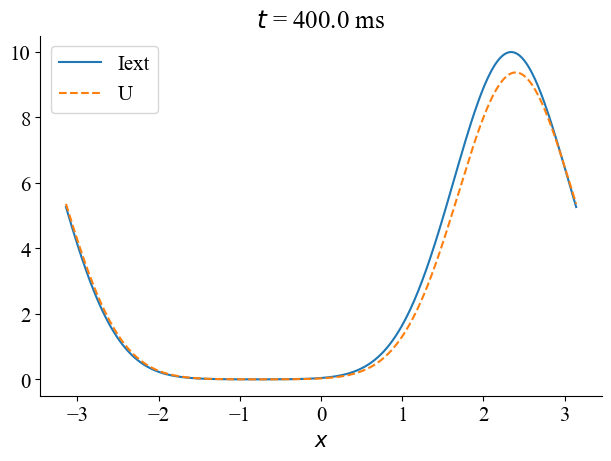

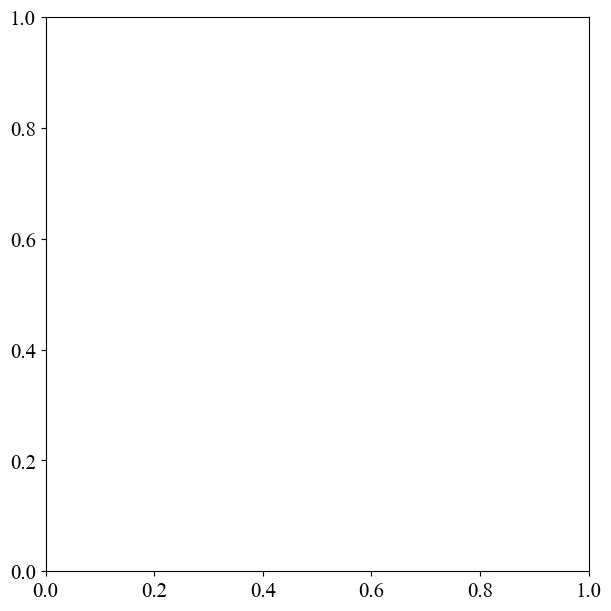

In [75]:
import numpy as np
def anticipative_tracking(m=10,v_ext=6*1e-3):
    cann_sfa = CANN1D_SFA(num=512, m=m)
    
    # 定义随时间变化的外部刺激
    v_ext = v_ext
    dur1, dur2, = 10., 1000.
    num1 = int(dur1 / bm.get_dt())
    num2 = int(dur2 / bm.get_dt())
    position = np.zeros(num1 + num2)
    for i in range(num2):
        pos = position[i+num1-1]+v_ext*bm.dt
        # the periodical boundary
        pos = np.where(pos>np.pi, pos-2*np.pi, pos)
        pos = np.where(pos<-np.pi, pos+2*np.pi, pos)
        # update
        position[i+num1] = pos
    position = position.reshape((-1, 1))
    Iext = cann_sfa.get_stimulus_by_pos(position)

    # 运行模拟
    runner = bp.DSRunner(cann_sfa,
                         inputs=['input', Iext, 'iter'],
                         monitors=['u'],
                         dyn_vars=cann_sfa.vars())
    runner.run(dur1 + dur2)

    # 可视化
    def plot_response(t, extra_fun=None):
        fig, gs = bp.visualize.get_figure(1, 1, 4.5, 6)
        ax = fig.add_subplot(gs[0, 0])
        ts = int(t / bm.get_dt())
        I, u = Iext[ts], runner.mon.u[ts]
        ax.plot(cann_sfa.x, I, label='Iext')
        ax.plot(cann_sfa.x, 10*u, linestyle='dashed', label='U')
        ax.set_title(r'$t$' + ' = {} ms'.format(t))
        ax.set_xlabel(r'$x$')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend()

    plot_response(t=10.)
    plot_response(t=200.)
    plot_response(t=400.)
    bp.visualize.animate_1D(
        dynamical_vars=[{'ys': runner.mon.u, 'xs': cann_sfa.x, 'legend': 'u'},
                        {'ys': Iext, 'xs': cann_sfa.x, 'legend': 'Iext'}],
        frame_step=5,
        frame_delay=50,
        show=True,
    )
    plt.show()
anticipative_tracking()

# Continuous Attractor Neural Network with STP
## The dynamics of CANN with STP
### Synaptic current dynamics (short-term plasticity variable $u,h$ is added to the model): 
$$ 
\tau \frac{dU(x,t)}{dt} = -U(x,t)+ \int_x' g^+(x')+ h(x',t)J(x,x')r(x',t)dx' + I^{ext} - V(x,t)
$$
### STP dynamics (modeling the available fraction and release probability of neuro-transmitter): 
$$ 
\tau \frac{dg(x,t)}{dt} = -\frac{g(x,t)}{\tau_f}+ G(1-g^-(x))r(x,t)
$$
$$ 
\tau \frac{dh(x,t)}{dt} = \frac{1-h(x,t)}{\tau_d}+ g^+(x)x(x,t)r(x,t)
$$
## Customize a CANN with STP

In [109]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 15})
plt.rcParams['font.sans-serif'] = ['Times New Roman']


class CANN1D_STP(bp.NeuGroupNS):
  def __init__(self, num, tau=1., tau_f=1., tau_d=30., G=0.2, k=8.1, a=0.5, A=10., J0=12.,
               z_min=-bm.pi, z_max=bm.pi, **kwargs):
    super(CANN1D_STP, self).__init__(size=num, **kwargs)

    # 初始化参数
    self.tau = tau
    self.tau_f = tau_f #time constant of u
    self.tau_d = tau_d #time constant of h
    self.G = G
    self.k = k
    self.a = a
    self.A = A
    self.J0 = J0
      
    # 初始化特征空间相关参数
    self.z_min = z_min
    self.z_max = z_max
    self.z_range = z_max - z_min
    self.x = bm.linspace(z_min, z_max, num)
    self.rho = num / self.z_range
    self.dx = self.z_range / num

    # 初始化变量
    self.u = bm.Variable(bm.zeros(num))
    self.g = bm.Variable(bm.zeros(num)) #neuro-transmitter release probability
    self.h = bm.Variable(bm.ones(num)) #neuro-transmitter available fraction
    self.input = bm.Variable(bm.zeros(num))
    self.conn_mat = self.make_conn(self.x)  # 连接矩阵

    # 定义积分函数
    self.integral = bp.odeint(self.derivative)

  # 微分方程
  @property
  def derivative(self):
    du = lambda u, t, Irec, Iext: (-u + Irec + Iext) / self.tau
    dg = lambda g, t, r: -g / self.tau_f + self.G * (1 - g) * r 
    dh = lambda h, t, g, r:  (1 - h) / self.tau_d - (g + self.G * (1 - g)) * h *r
    return bp.JointEq([du, dg, dh])

  # 将距离转换到[-z_range/2, z_range/2)之间
  def dist(self, d):
    d = bm.remainder(d, self.z_range)
    d = bm.where(d > 0.5 * self.z_range, d - self.z_range, d)
    return d

  # 计算连接矩阵
  def make_conn(self, x):
    assert bm.ndim(x) == 1
    d = self.dist(x - x[:, None])  # 距离矩阵
    Jxx = self.J0 * bm.exp(
      -0.5 * bm.square(d / self.a)) / (bm.sqrt(2 * bm.pi) * self.a) 
    return Jxx

  # 获取各个神经元到pos处神经元的输入
  def get_stimulus_by_pos(self, pos):
    return self.A * bm.exp(-0.25 * bm.square(self.dist(self.x - pos) / self.a))

  def update(self, x=None):
    u2 = bm.square(self.u)
    r = u2 / (1.0 + self.k * bm.sum(u2)) 
    Irec = bm.dot(self.conn_mat, (self.g + self.G * (1 - self.g))*self.h*r)
    u, g, h = self.integral(u=self.u, g=self.g, h=self.h, t=bp.share['t'], Irec=Irec, Iext=self.input, r=r, dt=bm.dt)
    self.u[:] = bm.where(u>0,u,0)
    self.g.value = g
    self.h.value = h
    self.input[:] = 0.  # 重置外部电流

## Simulate traveling wave in CANN with STP

  0%|          | 0/10000 [00:00<?, ?it/s]

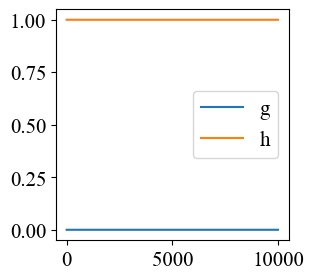

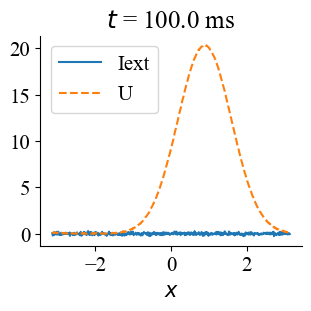

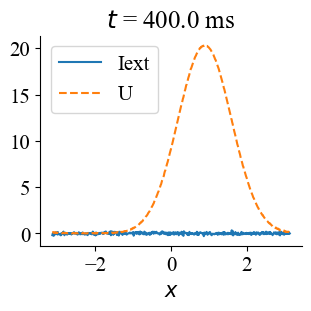

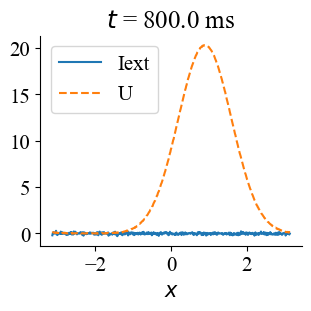

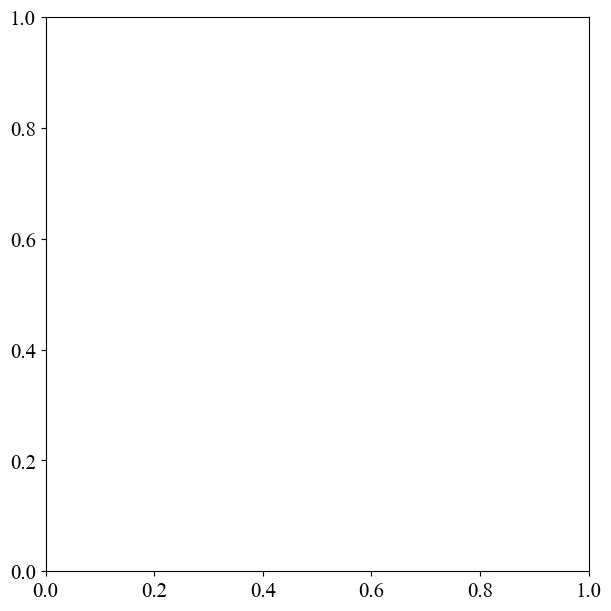

In [110]:
import numpy as np
def traveling_wave_STP(num=512,k=0.1,J0=12.,tau_d=1000,tau_f=1.,G=0.9):
    # 生成CANN
    cann_stp = CANN1D_STP(num=num, k=k,tau_d=tau_d,tau_f=tau_f,G=G, J0=J0)

    # 生成外部刺激
    dur = 1000.
    noise_level = 0.1
    Iext = bm.random.normal(0., noise_level, (int(dur / bm.get_dt()), num))
    duration = dur
    # 运行数值模拟
    runner = bp.DSRunner(cann_stp, inputs=['input', Iext, 'iter'], monitors=['u','g','h'])
    runner.run(duration)
    fig,ax = plt.subplots(figsize=(3,3))
    u = bm.as_numpy(runner.mon.u)
    max_index = np.argmax(u[1000,:])
    print(max_index)
    ax.plot(runner.mon.g[:,max_index],label='g')
    ax.plot(runner.mon.h[:,max_index],label='h')
    ax.legend()
    # 可视化
    def plot_response(t):
        fig, gs = bp.visualize.get_figure(1, 1, 3, 3)
        ax = fig.add_subplot(gs[0, 0])
        ts = int(t / bm.get_dt())
        I, u = Iext[ts], runner.mon.u[ts]
        ax.plot(cann_stp.x, I, label='Iext')
        ax.plot(cann_stp.x, u, linestyle='dashed', label='U')
        ax.set_title(r'$t$' + ' = {} ms'.format(t))
        ax.set_xlabel(r'$x$')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend()
    plot_response(t=100.)
    plot_response(t=400.)
    plot_response(t=800.)

    bp.visualize.animate_1D(
        dynamical_vars=[{'ys': runner.mon.u, 'xs': cann_stp.x, 'legend': 'u'},
                        {'ys': Iext, 'xs': cann_stp.x, 'legend': 'Iext'}],
        frame_step=1,
        frame_delay=40,
        show=True,
    )
    plt.show()
    
traveling_wave_STP(G=0.3,tau_d=500)